In [42]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os

In [3]:
input_path = '/Volumes/Behaviour/2P Tailoring Test Input'
output_path = '/Volumes/Behaviour/Tailored 3sec 2P Trials Test'
beh_stim = pd.read_csv('/Volumes/Behaviour/stimframes.csv', index_col=0)

In [43]:
#analysis PC paths
input_path = r'I:\Data to test Aras 2P code\S1 2P Recordings for Suite2P'
output_path = r'I:\Data to test Aras 2P code\Tailored Short 2P Trials'
beh_stim = pd.read_csv(r'I:\Data to test Aras 2P code\S1 2P Recordings for Suite2P\stimframes.csv', index_col=0)

In [56]:
directories = [x[0] for x in os.walk(input_path) if os.path.basename(x[0]) == 'plane0']

for directory in directories:
    print('Processing:', directory)
    stop = False
    meta = directory.split('/')  #directory.split('\\') 
    session_name = meta[4] #meta[3] 
    print(session_name)
    
    # load Suite2P outputs
    F = np.load(os.path.join(directory, 'F.npy'))
    Fneu = np.load(os.path.join(directory, 'Fneu.npy'))
    iscell = np.load(os.path.join(directory,'iscell.npy'), allow_pickle=True)
                             
    # read trial timings
    sf_path = meta[0]+'/'+meta[1]+'/'+meta[2]+'/'+meta[3] +'/'+ meta[4]
    sf = pd.read_csv(os.path.join(sf_path, '2P_stimframes.csv'))
    sf = sf.drop(sf.index[sf['stim_qc'] == 'removed']) # discard 2p timings for trials where behaviour videos were deleted because of qc
    cols = list(sf.columns)
    temp_stim = beh_stim[beh_stim['identifier'].str.contains(str(cols[0]))] # subset stimframes to the session being processed
    
    stimuli = list(sf['stimulus'])
    
    for s, stimulus in enumerate(stimuli):
        temp2_stim = temp_stim[temp_stim['identifier'].str.contains(str(stimulus))] # subset to one stimulus
        values = list(temp2_stim['sframe']) # get list of stimframes for one stimulus
        ids = list(temp2_stim['identifier'])
        sf.loc[sf['stimulus']==stimulus,'sframe']  = values
        sf.loc[sf['stimulus']==stimulus, 'identifier'] = ids
        
    sf_qc = sf.drop(sf.index[sf['sframe'] == 'DO NOT USE']) # keep only trials that passed behavioural qc
    sf_qc = sf_qc[~sf_qc[session_name].isnull()] # remove trial without 2P recording
    sf_qc['beh_stim_ms'] = (sf_qc['sframe'].astype(int)*2.5)+2.5 # convert behaviour stimulation frame to msec and add offset (1 frame in ms)
    sf_qc['2p_realstim_frame'] = sf_qc[session_name] + ((sf_qc['beh_stim_ms'] - 163.9) / 163.9)
    sf_qc['2p_realstim_frame'] = sf_qc['2p_realstim_frame'].apply(np.ceil) # round up to next completed frame
    
    sf_qc.to_csv(os.path.join(sf_path, '2P_SF_QC.csv'))
    
    stimframes = np.array(sf_qc['2p_realstim_frame'])
    idx = list(sf_qc['identifier'])
    
    # Subtract neuropil signal from raw traces
    Fc = F - 0.7 * Fneu
    print('matrix shape: ', F.shape)
    
    # Get list of ROIS that are not cells
    iscell = pd.DataFrame(iscell)
    iscell_idx = iscell[0] == 1
    
    # Remove non-cell ROIs from raw traces & raw traces without neuropil
    df_F = pd.DataFrame(F)
    F_isCell = df_F.loc[iscell_idx]
    
    df_Fc = pd.DataFrame(Fc)
    Fc_isCell = df_Fc.loc[iscell_idx]
                             
    # remove ROIs with zero values from raw traces and get new list of indecis corresponding to active ROIs
    F_nonZero = F_isCell.loc[~(F_isCell==0).all(axis=1)]
    activeROIs = list(F_nonZero.index.values)
    print('number of active rois: ', len(activeROIs))

    # keep only active ROIs in F-neuropil
    Fc_Act = df_Fc.loc[df_Fc.index[activeROIs]]
    print('active rois matrix shape: ', Fc_Act.shape)
                             
    if stimframes[0]-183 <0: # determine appropriate length of pre-stimulus baseline based on the number 
        TBL_len = stimframes[0]-1 # of frames available before the very first stimulation
    else:
        TBL_len = 183 # default baseline is 30 s (30 * 6.1 fps = 183)
        
# for each active ROI, calculate 5th percentile, then cut out 30 sec pre-, and 60 sec post-stimulation 
# traces and use these to calculate F0 (I call it T0 since it is trial based) as the mean of Q5 in the trial window.
# Then, compute trial-wise dF_F0 (I called them dT_T0) an crop those to a 3 second window centered sround stimulation.

    dF_F0_short, dF_F0_long = pd.DataFrame(), pd.DataFrame()
    for r, roi in enumerate(activeROIs):
       
        Fc_Q05 = Fc_Act.iloc[r,:].rolling(366, center = True).quantile(0.05) # 5th percentile of neuropil-corrected F trace
        
        tailored_short,  tailored_long = pd.DataFrame(), pd.DataFrame()
        
        for s in stimframes:
            start = int(s) - int(TBL_len)
            end = int(s) + 366 # 60 sec * 6.1 fps
            T = Fc_Act.iloc[r,start:end] # trial window of neuropil-corrected F trace
            T_Q05 = Fc_Q05.iloc[start:end] # trial window of 5th percentile trace
            T0 = T_Q05.mean()
            dT_T0_long = (T - T0)/T0
            tailored_long = pd.concat([tailored_long, dT_T0_long], axis=0)
            
            start_short = int(s) - 9 
            end_short = int(s) + 9
            dT_T0_short = dT_T0_long.loc[start_short:end_short]
            tailored_short = pd.concat([tailored_short, dT_T0_short], axis=0)
            
        new_name = session_name + '_' + str(roi)
        dF_F0_long[new_name] = tailored_long[0]
        dF_F0_short[new_name] = tailored_short[0]
    
    print('last trial length: ', dT_T0_short.shape) # checking length of last trial in frames
    
    # add identifier column to dF_F0 dataframes 
    ids = []
    for i in idx:
        for n in range(19):
            ids.append(i)                                       
    ids = np.array(ids) 
    
    dF_F0_short['identifier'] = ids
 
    dF_F0_short.to_csv(os.path.join(output_path,'dF_F0_SHORT_' +session_name+'.csv'))


Processing: I:\Data to test Aras 2P code\S1 2P Recordings for Suite2P\2P07_Ses03\suite2p\plane0
2P07_Ses03
matrix shape:  (1003, 19396)
number of active rois:  491
active rois matrix shape:  (491, 19396)


C:\Users\Browne_lab\Anaconda3\envs\Analysis of DLC\lib\site-packages\ipykernel_launcher.py:97: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
C:\Users\Browne_lab\Anaconda3\envs\Analysis of DLC\lib\site-packages\ipykernel_launcher.py:98: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


last trial length:  (19,)


C:\Users\Browne_lab\Anaconda3\envs\Analysis of DLC\lib\site-packages\ipykernel_launcher.py:109: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


0


C:\Users\Browne_lab\Anaconda3\envs\Analysis of DLC\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """


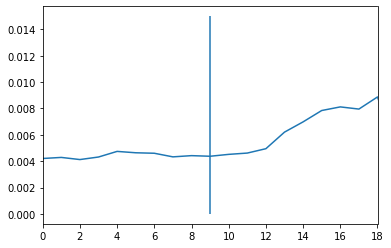

1


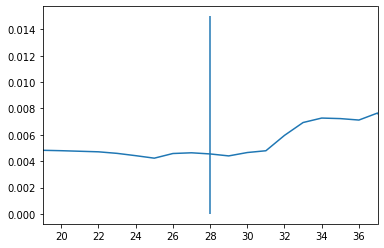

2


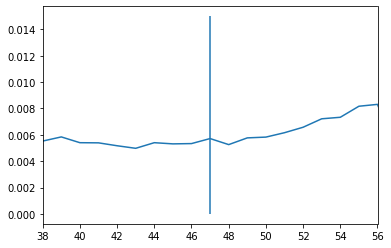

3


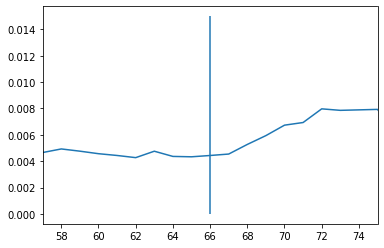

4


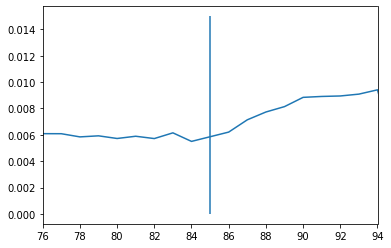

5


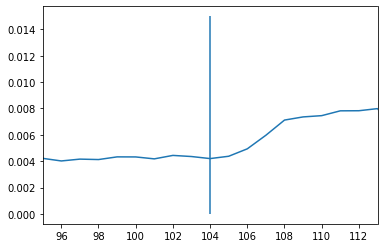

6


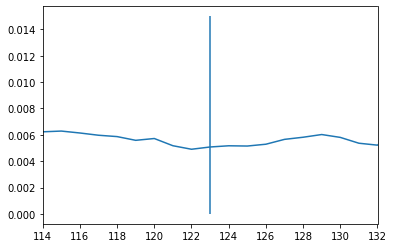

7


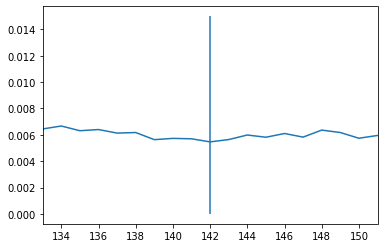

8


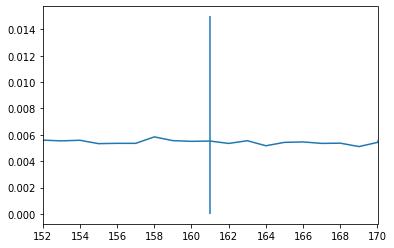

9


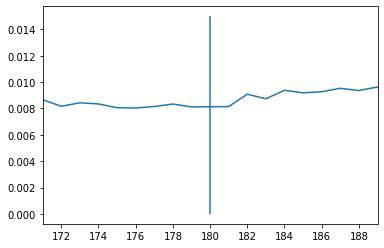

10


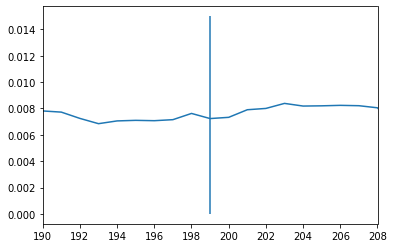

11


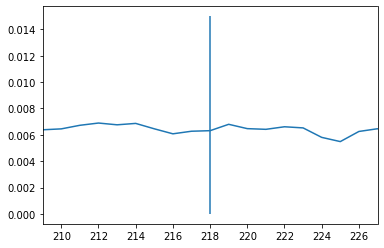

12


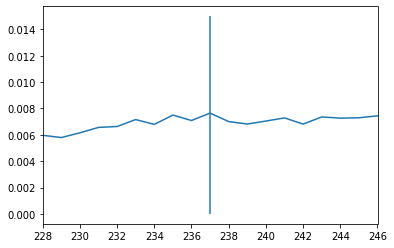

13


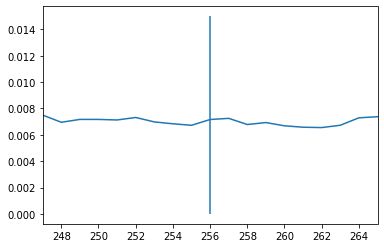

14


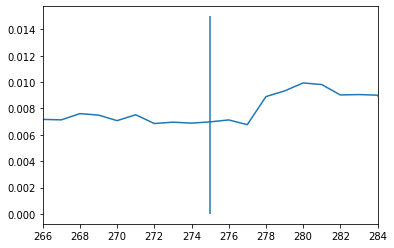

15


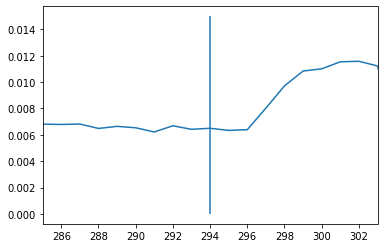

16


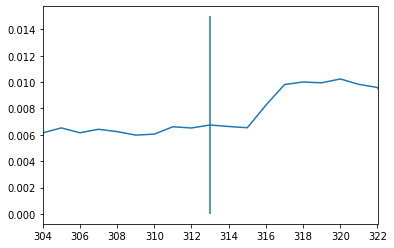

17


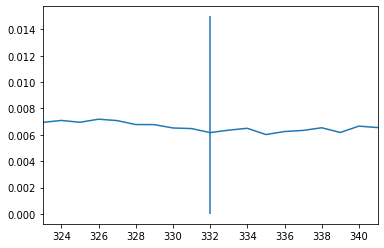

18


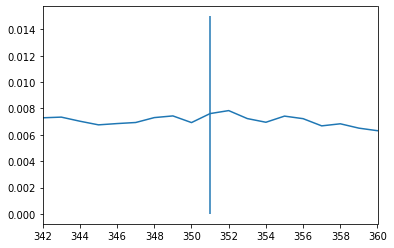

19


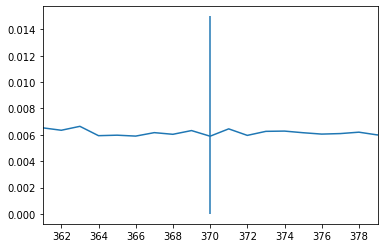

20


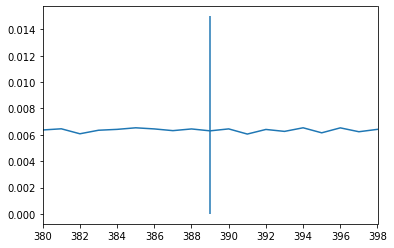

21


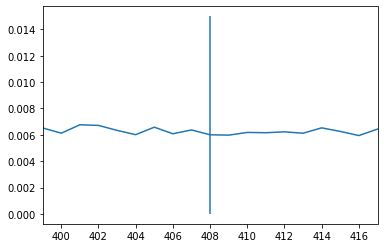

In [68]:
for stim in range(22):
    print(stim)
    stim = ((10+9)*stim)+9
    plt.figure()
    plt.plot(dF_F0_short.mean(axis=1).reset_index(drop=True))
    plt.vlines((stim),0,0.015)
    plt.xlim((stim-9,stim+9))
    plt.show()

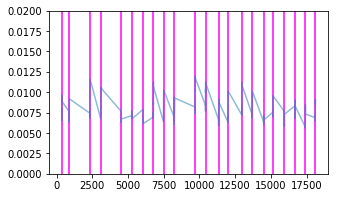

In [34]:
plt.figure(figsize=(5, 3))
#plt.plot(dF_F0.iloc[:,200], alpha=0.5)
plt.plot(dF_F0.mean(axis=1), alpha=0.5)
plt.ylim([0.0,0.02])
#plt.xlim([8220,8260])
plt.eventplot(stimframes, color = 'fuchsia', linelength = 800)
plt.show()